In [1]:
import backtrader as bt
import yfinance as yf
import pyfolio as pf
import pandas as pd

/opt/anaconda3/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
class PMAStrategy(bt.Strategy):

    def __init__(self):
        # Inicijalizacija SMA indikatora
        self.sma = bt.indicators.SMA(self.data.close, period=10)  # Možete promijeniti period po želji
        self.order = None

    def next(self):
        if self.order:  # Ako postoji otvorena narudžba, ne radimo ništa
            return

        # Kupi, ako je Pt veći od MAt(n)
        if not self.position and self.data.close[0] > self.sma[0]:
            cash = self.broker.get_cash()
            price = self.data.close[0]
            shares_to_buy = cash // price
            if shares_to_buy > 0:            
                self.log('Kreiraj Kupnju, %.2f' % self.data.close[0])
                self.order = self.buy(size=shares_to_buy)

        # Prodaj, ako je Pt manji od MAt(n)
        elif self.position and self.data.close[0] < self.sma[0]:
            self.log('Kreiraj Prodaju, %.2f' % self.data.close[0])
            self.order = self.sell(size=self.position.size)

    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status == order.Completed:
            if order.isbuy():
                self.log(
                "Izvršena KUPNJA (Cijena: %.2f, Vrijednost: %.2f, Provizija %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            else:
                self.log(
                "Izvršena PRODAJA (Cijena: %.2f, Vrijednost: %.2f, Provizija %.2f)" %
                (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Narudžba je otkazana/margina/odbijena")
        self.order = None


In [3]:
def test_strategy(strategy_class, ticker, start_date, end_date, starting_cash=100000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    
    # Preuzimamo podatke i spremamo ih u varijablu
    yf_data = yf.download(ticker, start=start_date, end=end_date)
    data = bt.feeds.PandasData(dataname=yf_data)
    cerebro.adddata(data)
    
    cerebro.broker.setcash(starting_cash)
    cerebro.broker.setcommission(commission=0.0002)
    
    # Dodajemo observer za praćenje vrijednosti portfolija
    cerebro.addobserver(bt.observers.Value)
    
    # Dodajemo analizator za praćenje povrata
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    
    print('Početno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run()
    print('Završno stanje portfelja: %.2f' % cerebro.broker.getvalue())
    
    strat = results[0]
    
    # Dohvaćamo podatke iz PyFolio analizatora
    portfolio_value = strat.analyzers.pyfolio.get_pf_items()
    returns, positions, transactions, gross_lev = portfolio_value

    # Dohvaćamo vrijednosti portfolija
    portfolio_values = strat.observers.value.get(size=len(strat))
    
    # Stvaramo DataFrame s datumima i vrijednostima portfolija
    df_portfolio = pd.DataFrame({
        'Date': yf_data.index,
        'Value': portfolio_values
    })    
    
    # Koristimo pyfolio za generiranje izvještaja
    pf.create_simple_tear_sheet(returns)

    return df_portfolio

[*********************100%%**********************]  1 of 1 completed

Početno stanje portfelja: 100000.00
2024-01-16, Kreiraj Kupnju, 56.38
2024-01-17, Izvršena KUPNJA (Cijena: 56.35, Vrijednost: 99903.23, Provizija 19.98)
2024-02-20, Kreiraj Prodaju, 69.45
2024-02-21, Izvršena PRODAJA (Cijena: 68.01, Vrijednost: 99903.23, Provizija 24.11)
2024-02-22, Kreiraj Kupnju, 78.54
2024-02-23, Narudžba je otkazana/margina/odbijena
2024-02-23, Kreiraj Kupnju, 78.82
2024-02-26, Narudžba je otkazana/margina/odbijena
2024-02-26, Kreiraj Kupnju, 79.09
2024-02-27, Narudžba je otkazana/margina/odbijena
2024-02-27, Kreiraj Kupnju, 78.70
2024-02-28, Izvršena KUPNJA (Cijena: 77.62, Vrijednost: 118913.84, Provizija 23.78)
2024-03-15, Kreiraj Prodaju, 87.84
2024-03-18, Izvršena PRODAJA (Cijena: 90.39, Vrijednost: 118913.84, Provizija 27.69)
2024-03-19, Kreiraj Kupnju, 89.40
2024-03-20, Narudžba je otkazana/margina/odbijena
2024-03-20, Kreiraj Kupnju, 90.37
2024-03-21, Narudžba je otkazana/margina/odbijena
2024-03-21, Kreiraj Kupnju, 91.43
2024-03-22, Izvršena KUPNJA (Cijena:


/opt/anaconda3/lib/python3.11/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '175.011%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2024-01-02
End date,2024-07-30
Total months,6
,Backtest
Annual return,175.011%
Cumulative returns,78.979%
Annual volatility,36.361%
Sharpe ratio,2.97
Calmar ratio,13.07
Stability,0.87
Max drawdown,-13.39%


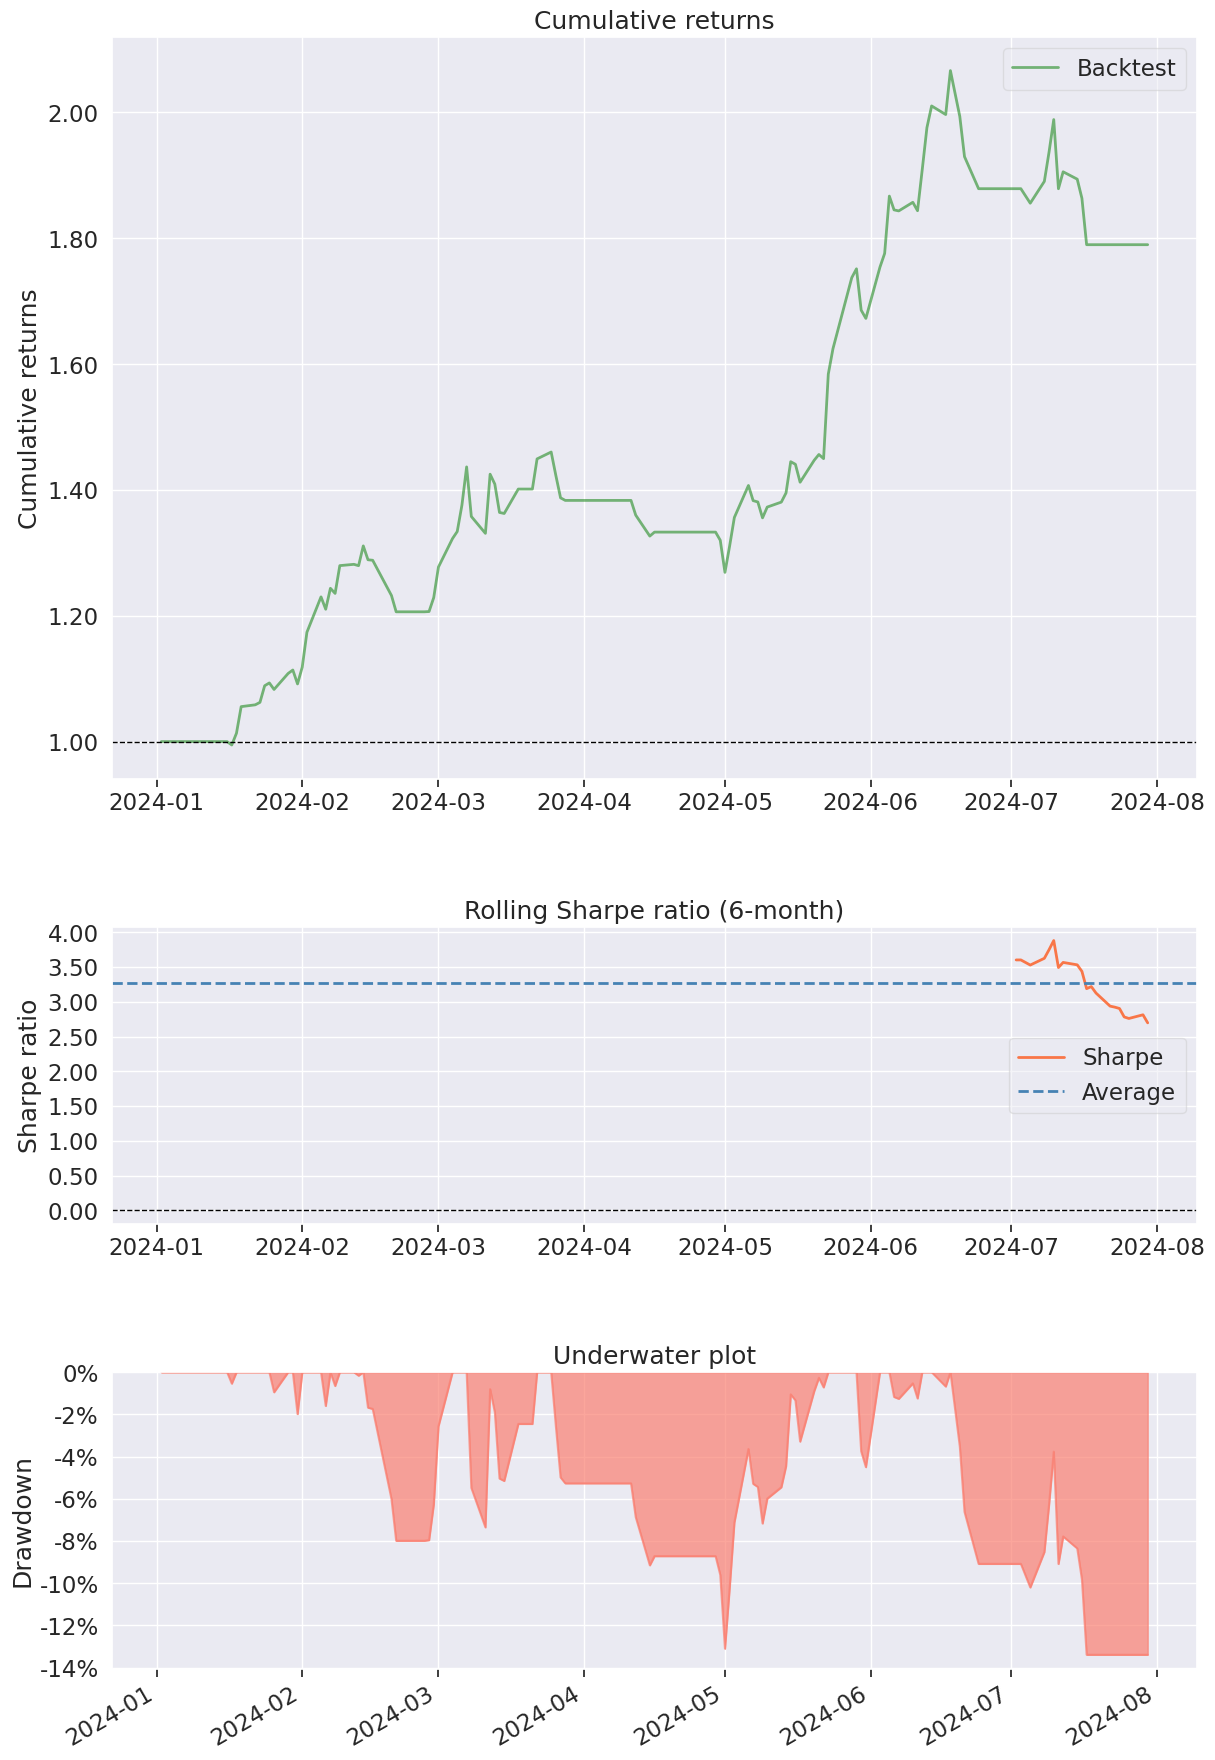

In [4]:
results = test_strategy(PMAStrategy, 'NVDA', '2024-01-01', '2024-07-31')

In [5]:
import pickle

# Za df_account_value_sac
with open('nvda_p_ma_strategy.pkl', 'wb') as f:
    pickle.dump(results, f)